In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_breast_cancer()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [2]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 
# Select only the desired features
data_X = X.to_numpy()

# Encode y to be +1 and -1
le = LabelEncoder()
data_y = le.fit_transform(y)
data_y[data_y == 0] = -1  # Replace 0 with -1

[Text(0.5, 0, 'mean radius'), Text(0, 0.5, 'mean concave points')]

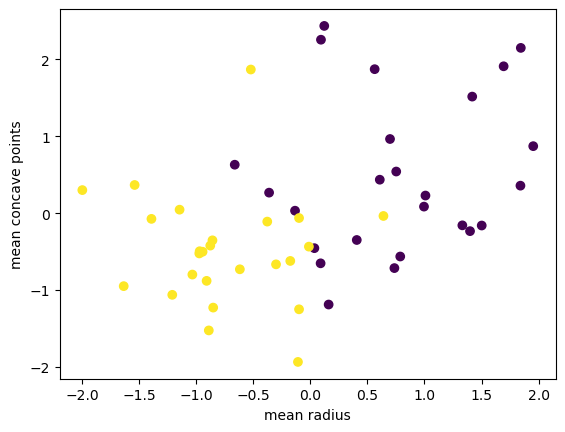

In [3]:
n = 50
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='mean radius', ylabel='mean concave points')

In [4]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.legend()
    #plt.title('Soft Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['CVX Solution', 'ODE Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()
    
def plot_svm_decision_boundary_confrontation_PINN(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['ODE Solution', 'PINN Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()

In [5]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b']
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

In [6]:
def hyperplane_similarity(w, b, w_opt, b_opt, alpha=0.5, beta=0.5):
    """
    Computes a metric to measure the similarity between two hyperplanes defined by (w, b) and (w_opt, b_opt).
    
    Parameters:
    - w (np.ndarray): Normal vector of the first hyperplane.
    - b (float): Offset of the first hyperplane.
    - w_opt (np.ndarray): Normal vector of the optimal hyperplane.
    - b_opt (float): Offset of the optimal hyperplane.
    - alpha (float): Weight for the angular difference metric. Default is 0.5.
    - beta (float): Weight for the offset difference metric. Default is 0.5.
    
    Returns:
    - float: Combined metric value. Closer to 0 indicates more similar hyperplanes.
    """
    # Normalize vectors for angle computation
    norm_w = np.linalg.norm(w)
    norm_w_opt = np.linalg.norm(w_opt)
    
    # Handle edge cases for zero vectors
    if norm_w == 0 or norm_w_opt == 0:
        raise ValueError("The normal vector of a hyperplane cannot be a zero vector.")
    
    # Compute cosine similarity and angle metric
    cos_theta = np.dot(w, w_opt) / (norm_w * norm_w_opt)
    angle_metric = 1 - cos_theta
    
    # Normalize vectors to unit length for offset comparison
    w_unit = w / norm_w
    w_opt_unit = w_opt / norm_w_opt
    
    # Compute the offset difference metric
    offset_diff = abs(b / norm_w - b_opt / norm_w_opt)
    offset_metric = offset_diff / max(abs(b / norm_w), abs(b_opt / norm_w_opt), 1)
    
    # Combine metrics
    combined_metric = alpha * angle_metric + beta * offset_metric
    return combined_metric

# CVX

Time: 0.02148294448852539
Optimal objective value: 1.091963640992599
SCS solver iterations: 175
SCS solve time: 0.003651352
SCS setup time: 0.002294529
Optimal w:  [-0.16904065 -0.15084259 -0.13769055 -0.190649    0.24223962  0.30311275
 -0.02737322 -0.10442718  0.18534815  0.05973499 -0.14090515  0.13701861
 -0.12480188 -0.25409847 -0.45110512  0.14876903  0.05457625 -0.06517936
  0.03919083 -0.02395683 -0.25929888 -0.56309408 -0.20263322 -0.26051275
 -0.76430209  0.03950618 -0.15383719 -0.37957779 -0.26553547 -0.45422772]
Optimal b:  [-0.56558186]
Dual variables (Lagrange multipliers): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02604948 0.         0.85999657
 0.0542879  0.         0.04485696 0.         0.         0.13466972
 0.         0.2912272  0.         0.         0.         0.24745191
 0.         0.         0.0430392  0.         0.         0.0417621
 0.         0.      

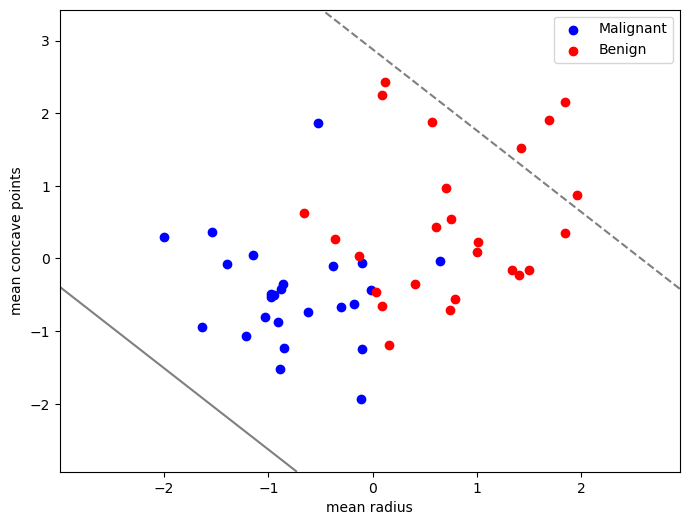

In [7]:
import cvxpy as cp
import numpy as np
import time

C = 10

num_features = selected_X.shape[1]

w = cp.Variable(num_features)
b = cp.Variable(1)
xi = cp.Variable(selected_y.shape[0])

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2 + C * cp.sum(xi))

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1 - xi,
    xi >= 0
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g_1 = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_2 = [np.array([-xi.value[i]]) for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g_1 + g_2).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

wb_cvx = np.concatenate([w.value, b.value])

# ODE

In [8]:
nw = selected_X.shape[1]
nb = 1
nxi = selected_y.shape[0]
nx = nw + nb + nxi
nu = selected_X.shape[0] * 2
NY = nx+nu

def f(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    output = (1/2) * jnp.linalg.norm(w, 2)**2 + C * jnp.sum(xi)
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    g_1 = [-selected_y[i] * (w @ selected_X[i] + b) + 1 - xi[i] for i in range(selected_y.shape[0])]
    g_2 = [- xi[i] for i in range(selected_y.shape[0])]
    output = jnp.array(g_1 + g_2)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)


In [9]:

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.01).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def evaluation_plus(xu):
    x, u= xu[:nx], xu[nx:]
    lim = None
    if (g(x)<=0.001).all():
        lim = 0.001
    elif (g(x)<=0.01).all():
        lim = 0.01
    elif (g(x)<=0.1).all():
        lim = 0.1
    elif (g(x)<=1).all():
        lim = 1
    return f(x), lim


In [10]:
def solve_ODE(xuv0, T):
    t0 = time.time()
    sol = solve_ivp(ODE, [0., T], xuv0, method=NUMERICAL_METHOD)
    solve_time = time.time() - t0
    print('Time:', solve_time)
    result = P(sol.y[:, -1])
    
    obj, lim = evaluation_plus(result)
    print("objective:", obj, "lim:", lim)
    
    print("objective:", obj)
    print("w: ", result[:nw], "b: ", result[nw])
    wb_ode = result[:nw+nb]
    similarity = hyperplane_similarity(result[:nw], result[nw], wb_cvx[:nw], wb_cvx[nw])
    print("hyperplane similarity:", similarity)
    print("Dual variables (alpha):", result[:nx])
    print("Constraints:",g(result[:nx]))
    
    return sol, result, obj, lim, similarity

# PINN

In [11]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i >= 1000 and all(x < 0.01 for x in L_loss[-5:]):
                break
            
            if i==ITERATIONS:
                break

        curr_net = deepcopy(net)
        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, curr_net, L_loss, time.time()-t0, i

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]

# Runs

In [12]:
def iteration(ip):
    xu0 = jnp.array(ip)
    y0 = ip
    
    # ODE Solution
    sol, result, obj, lim, similarity = solve_ODE(xu0, T)
    
    if lim == None:
        print('>>> Infeasible')
    else:
        print('>>> Feasible with epsilon:', lim, 'objective:', obj)

    print("hyperplane similarity:", similarity)
    if similarity < 0.01:
        print('>>> ODE Solution is accurate, last iteration')
        lastIter = True
    else:
        lastIter = False
        
    t_values = sol.t
    y_values = sol.y

    w_ode = result[:data_X.shape[1]]
    b_ode = result[data_X.shape[1]]

    plot_ode_system(t_values, y_values)

    plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)
    
    example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
    L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, net_curr, L_loss, t, n_iter = example.NN_method() # train
    print('epsilon:', L_epsilon[-1], 'time:', t, 'iterations:', n_iter)
    
    # ------------ NN plots ------------ 
    plt.plot(L_epsilon, marker='o', linestyle='-', label='OuC metric best', markersize=1)
    plt.plot(L_epsilon_curr, marker='o', linestyle='-', label='OuC metric current', markersize=1)
    plt.xlabel('iteration')
    plt.ylabel('OuC metric')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)

    plt.tight_layout()
    # Show the plot
    plt.show()
    
    print('Last losses:', L_loss[-10:])

    plt.plot(L_loss, label='Loss')
    plt.xlabel('iteration')
    plt.ylabel('Loss')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)
    plt.tight_layout()
    # Show the plot
    plt.show()
    
    if n_iter != ITERATIONS and lastIter:
        print('>>> NN Solution is accurate, last iteration')
        net = net_curr
        lastIter = True
    else:
        lastIter = False
        net = net_curr
    
    res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
    plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
    print('Variables:', res[:nx])
    print('Constraints:', g(res[:nx]))
    
    pinn_obj, lim_pin = evaluation_plus(res)
    
    print("objective pinn:", pinn_obj, "epsion pinn:", lim_pin)
    
    print("w: ", res[:nw], "b: ", res[nw])

    similarity_pinn = hyperplane_similarity(res[:nw], res[nw], wb_cvx[:nw], wb_cvx[nw])
    print("PINN hyperplane similarity:", similarity_pinn)
    
    return res, pinn_obj, lastIter

In [13]:
NBATCH = 512
WEIGTHING = 1
LAYERS = 2
NEURONS = 100
LR = 0.001
T = 20.0

>>>> ITERATION: 1


Time: 13.975044250488281


objective: 1.235284 lim: 0.01
objective: 1.235284
w:  [-0.16941911 -0.14861519 -0.13783615 -0.19053495  0.24424788  0.30549406
 -0.02898996 -0.10582302  0.18915355  0.06088885 -0.14085933  0.13536604
 -0.12416509 -0.25409952 -0.45346113  0.15118647  0.05491119 -0.06534218
  0.03860235 -0.02398753 -0.25996731 -0.56489562 -0.20296284 -0.26074075
 -0.76733168  0.03928733 -0.15671169 -0.38208216 -0.26657006 -0.45655607] b:  -0.5671593053897733
hyperplane similarity: 0.0002922380690079107
Dual variables (alpha): [-0.16941911 -0.14861519 -0.13783615 -0.19053495  0.24424788  0.30549406
 -0.02898996 -0.10582302  0.18915355  0.06088885 -0.14085933  0.13536604
 -0.12416509 -0.25409952 -0.45346113  0.15118647  0.05491119 -0.06534218
  0.03860235 -0.02398753 -0.25996731 -0.56489562 -0.20296284 -0.26074075
 -0.76733168  0.03928733 -0.15671169 -0.38208216 -0.26657006 -0.45655607
 -0.56715931  0.00049347  0.00049392  0.00049365  0.00049335  0.00049196
  0.00049348  0.00049298  0.00049356  0.00049206 

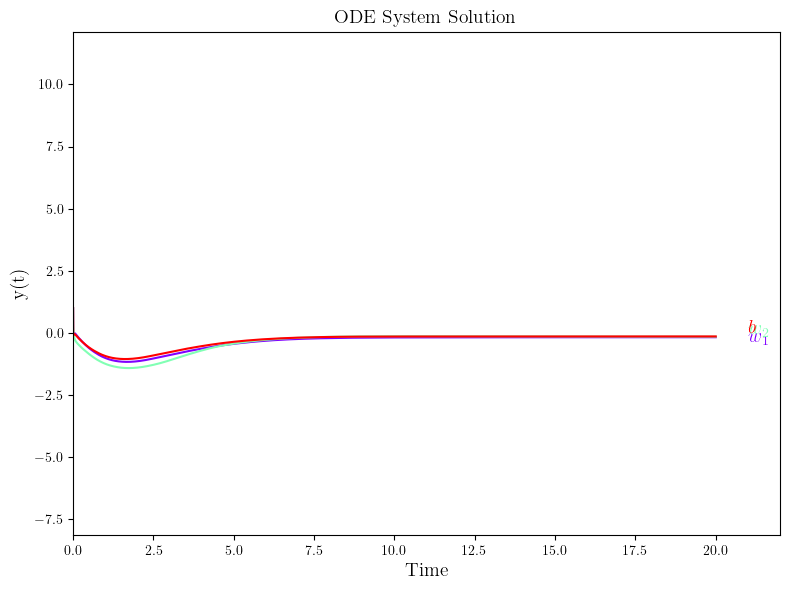

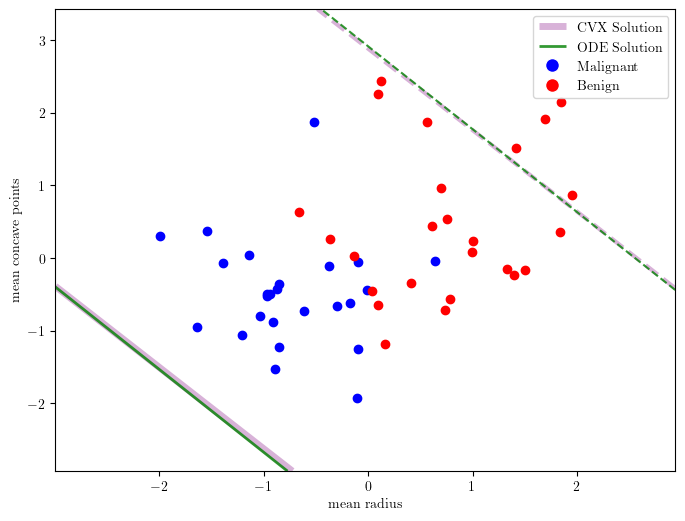

epsilon: 547.6867 time: 901.7670366764069 iterations: 2000


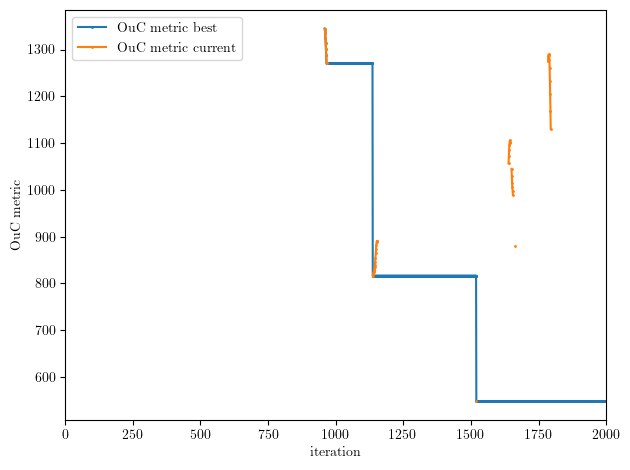

Last losses: [5630.85498046875, 1271.9755859375, 1598.552734375, 1445.6826171875, 2019.360107421875, 6904.4140625, 5784.8740234375, 15112.537109375, 2406.94970703125, 2115.794189453125]


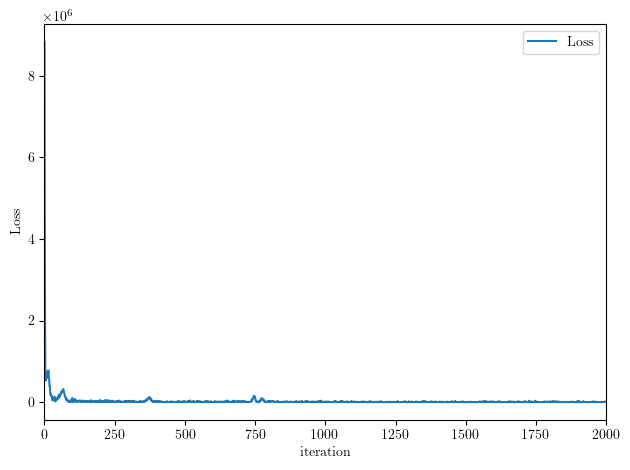

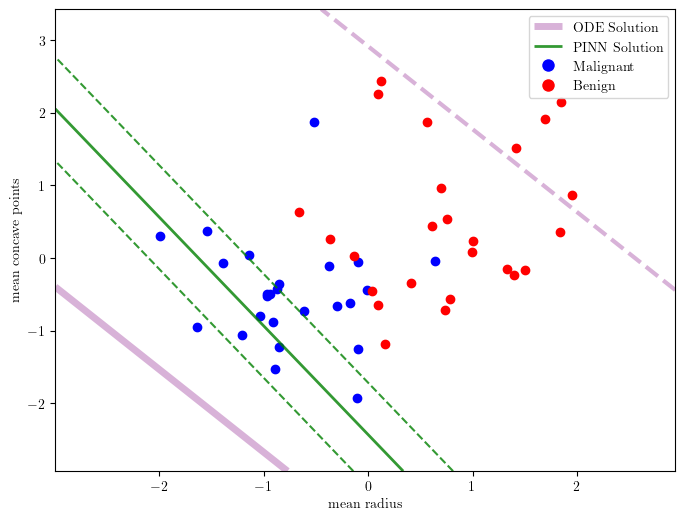

Variables: [-2.0929394  -1.3991599  -1.8663907  -1.8886075   0.7862524   0.50071466
 -0.5900707  -1.2363553   0.25837386  0.6878196  -1.4321055   1.226414
 -1.481946   -2.0988016  -3.6763463   0.5166284   1.0680839  -0.31279123
 -0.73491645  0.78167963 -2.4712744  -3.1961622  -2.217977   -2.2113712
 -5.007448   -0.8706273  -1.4213977  -2.666636   -2.6207237  -2.6859415
 -3.4042377  -0.35073006  0.11122254 -0.5549134  -0.35082248 -1.0945724
 -0.28676194 -0.29125863 -0.3586471  -1.0708162  -0.30125046 -0.54144675
 -0.30088145 -0.5654001  -0.45201838  0.38566303 -0.294446   -1.3854043
 -2.1830103   0.7733258  -0.6241415  -1.0369086  -0.32987487 -0.5933287
 -0.46524963 -0.40731457 -0.10386264 -0.1739862   0.46900696  0.8870002
 -0.61051357 -0.2950145  -0.5760032  -2.07569    -0.32785466 -0.34836817
 -0.06776186 -0.529944   -0.24782085 -0.33794612 -0.56946707 -0.46531639
 -1.1490271  -1.0384734  -0.07404432 -0.5541025  -0.43277916  0.16200688
 -0.41620454 -0.36456534 -0.36278105]
Constraint

Time: 9.816628217697144
objective: 1.1278499 lim: 0.01
objective: 1.1278499
w:  [-0.16895425 -0.14935054 -0.1375269  -0.19047419  0.2419895   0.30498078
 -0.02839276 -0.10399446  0.19092662  0.06089573 -0.14063151  0.13752086
 -0.12481258 -0.25311309 -0.45203002  0.14876707  0.05521136 -0.0658089
  0.03600629 -0.02354669 -0.25888428 -0.56141243 -0.2022483  -0.26008175
 -0.76263821  0.03805554 -0.1565641  -0.38093561 -0.26479581 -0.455232  ] b:  -0.5643891403122201
hyperplane similarity: 0.00041981557360945554
Dual variables (alpha): [-0.16895425 -0.14935054 -0.1375269  -0.19047419  0.2419895   0.30498078
 -0.02839276 -0.10399446  0.19092662  0.06089573 -0.14063151  0.13752086
 -0.12481258 -0.25311309 -0.45203002  0.14876707  0.05521136 -0.0658089
  0.03600629 -0.02354669 -0.25888428 -0.56141243 -0.2022483  -0.26008175
 -0.76263821  0.03805554 -0.1565641  -0.38093561 -0.26479581 -0.455232
 -0.56438914  0.00006661  0.00006087  0.00005804  0.00006866 -0.00000094
  0.00006967  0.00006823  

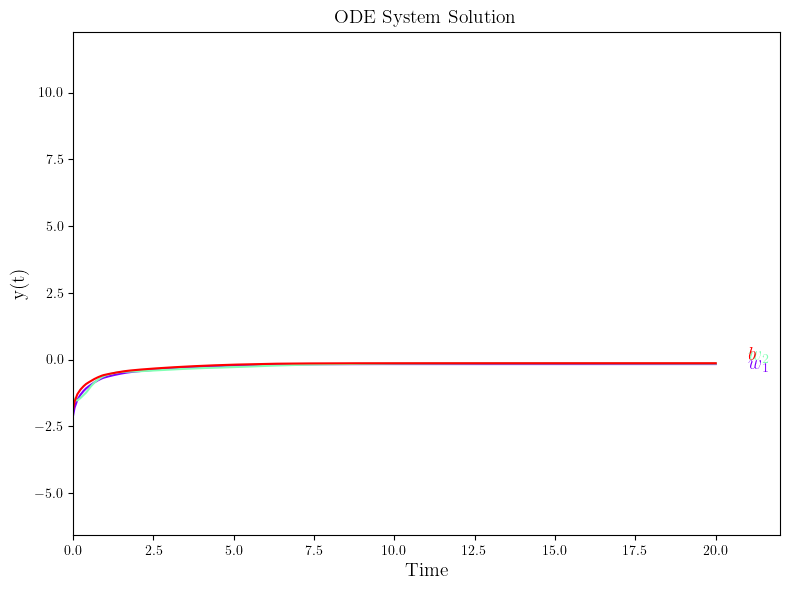

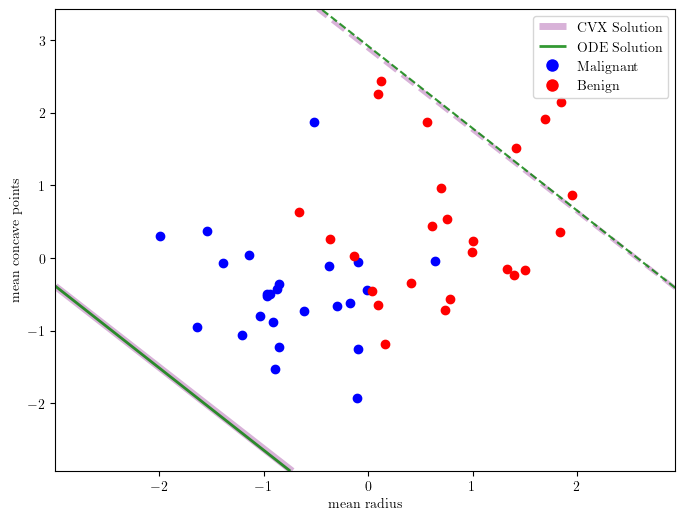

epsilon: inf time: 3850.24289727211 iterations: 10000


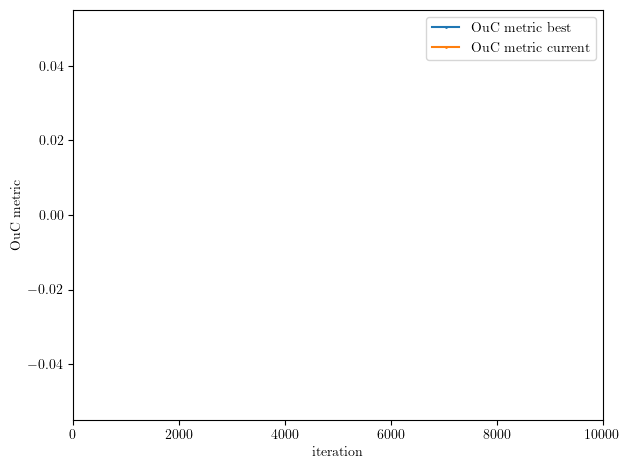

Last losses: [32.871360778808594, 38.72060012817383, 46.52738571166992, 50.080955505371094, 61.459503173828125, 69.6540298461914, 76.97785949707031, 80.45362854003906, 86.39042663574219, 95.93287658691406]


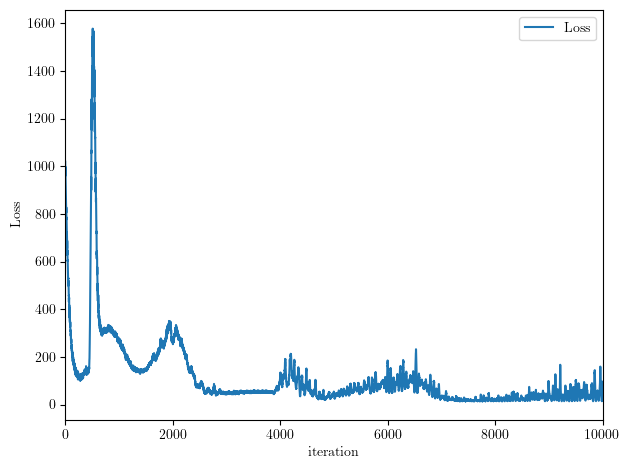

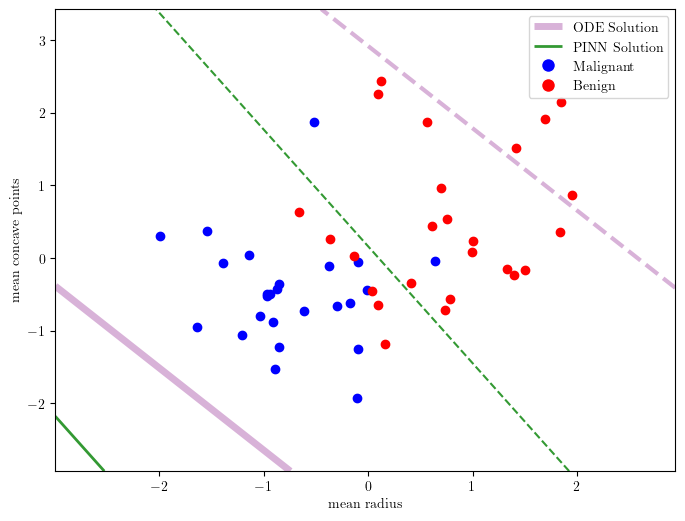

Variables: [-0.22454774 -0.13974226 -0.21115792 -0.23760056  0.10213315  0.2334513
 -0.12670755 -0.16409779  0.18308505  0.00374645 -0.30641687  0.14574969
 -0.24717784 -0.37973964 -0.4659431   0.1588552   0.05201042 -0.03459263
  0.08834046 -0.02918345 -0.35277772 -0.55039954 -0.28318202 -0.39267123
 -0.81536293 -0.07638204 -0.2890172  -0.39415097 -0.20943785 -0.5503442
 -0.97778463  0.110778    0.15855227  0.07954603  0.14128652  0.05826116
  0.14292175  0.16004652  0.1083644   0.01520765  0.11272109  0.08484566
  0.1393292   0.08451927  0.11169863  0.31801748  0.12113199 -0.06398129
 -0.15579224  0.26125467  0.08700716 -0.02028811  0.15002447  0.03392029
  0.17411873  0.10491887  0.03353111  0.15566364  0.20814198  0.24302864
  0.15369314  0.13221365  0.06825572 -0.0697248   0.13430256  0.14388403
  0.05921169  0.08271462  0.1320442   0.1253775   0.11486322  0.10530093
  0.1760701   0.02332914  0.1794633   0.08661675 -0.0211066   0.06082906
  0.12564847  0.12236553  0.11293983]
Cons

Time: 16.26104974746704
objective: 1.0926887 lim: 0.01
objective: 1.0926887
w:  [-0.1688419  -0.14869178 -0.13748334 -0.19008909  0.24354177  0.30188413
 -0.02817828 -0.10553662  0.18342979  0.06006206 -0.140565    0.1331234
 -0.12419268 -0.25410371 -0.4499268   0.14942455  0.05432305 -0.06387123
  0.04049098 -0.02340206 -0.25944553 -0.56417807 -0.20285018 -0.26029094
 -0.76530424  0.03937693 -0.15424403 -0.37902165 -0.26643946 -0.45328197] b:  -0.5647903451140076
hyperplane similarity: 0.00020025035729537288
Dual variables (alpha): [-0.1688419  -0.14869178 -0.13748334 -0.19008909  0.24354177  0.30188413
 -0.02817828 -0.10553662  0.18342979  0.06006206 -0.140565    0.1331234
 -0.12419268 -0.25410371 -0.4499268   0.14942455  0.05432305 -0.06387123
  0.04049098 -0.02340206 -0.25944553 -0.56417807 -0.20285018 -0.26029094
 -0.76530424  0.03937693 -0.15424403 -0.37902165 -0.26643946 -0.45328197
 -0.56479035 -0.00000406 -0.00000573 -0.00000243 -0.00000472  0.00000362
 -0.00000551 -0.00000508

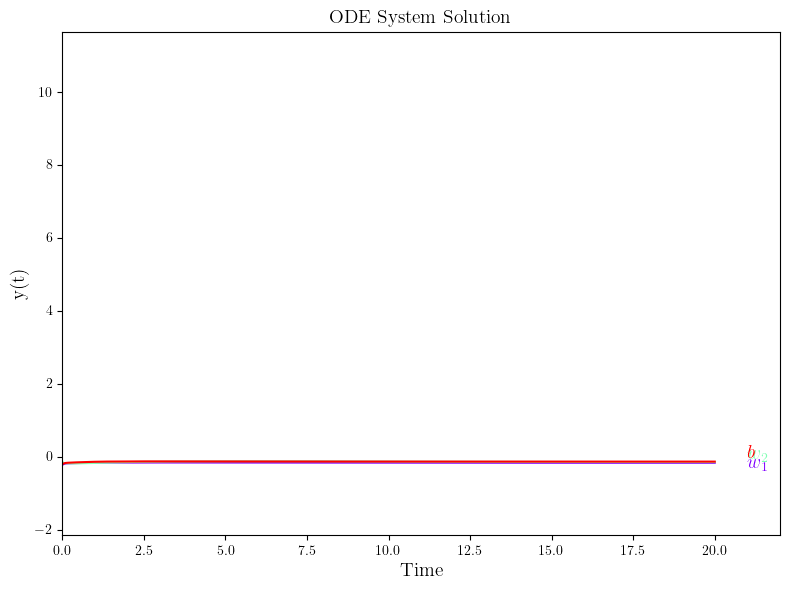

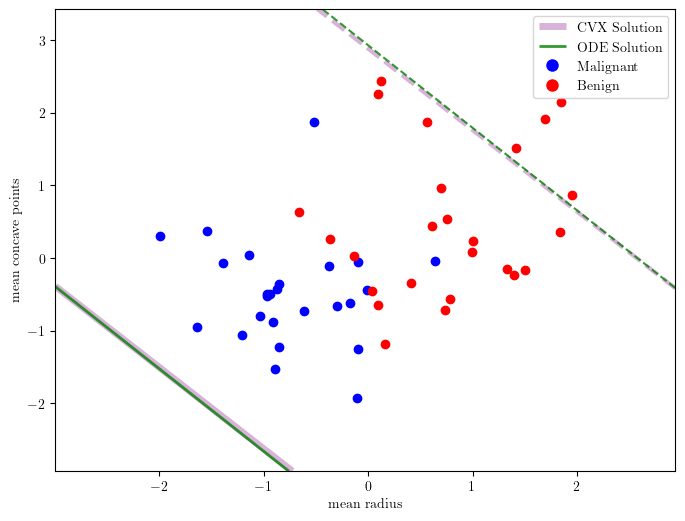

epsilon: inf time: 3802.5798077583313 iterations: 10000


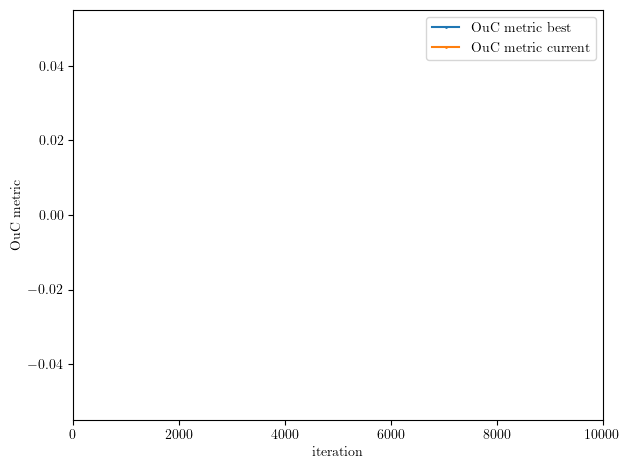

Last losses: [2.1105027198791504, 3.007356643676758, 3.608454704284668, 3.4371933937072754, 2.907182216644287, 2.2252702713012695, 2.129911422729492, 2.4694886207580566, 2.481797218322754, 3.0389323234558105]


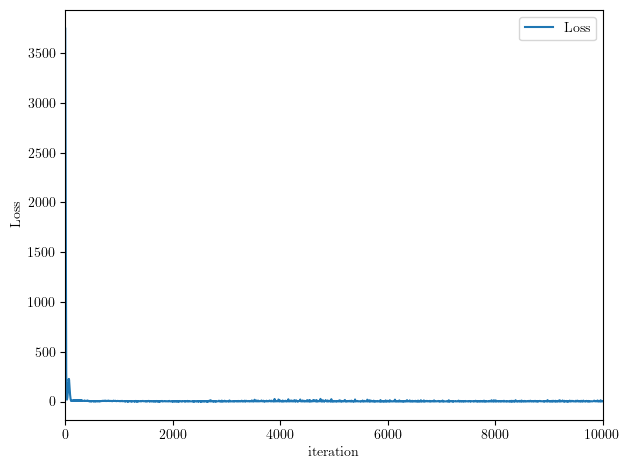

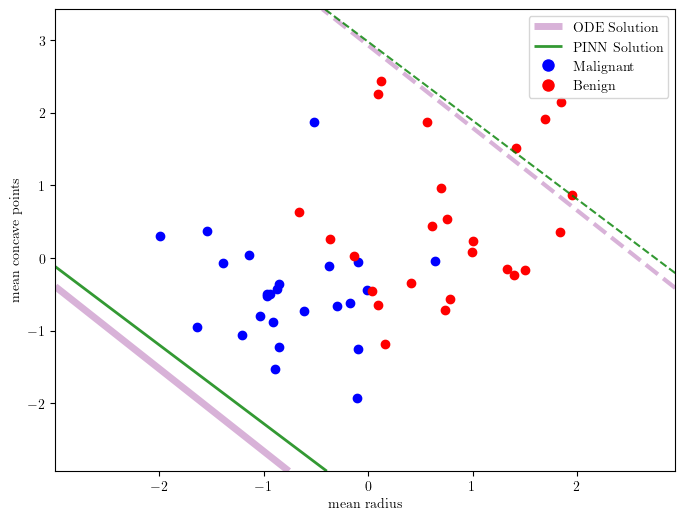

Variables: [-0.17072096 -0.15774913 -0.13472492 -0.16395488  0.26083294  0.29854694
 -0.02448584 -0.11803202  0.1696821   0.08295737 -0.12673146  0.08958586
 -0.10827443 -0.2468655  -0.44063076  0.16995834  0.07157806 -0.04716993
  0.05032915  0.02471814 -0.24758628 -0.57622665 -0.20474657 -0.24967566
 -0.76585567  0.02982999 -0.14979322 -0.36331475 -0.25915247 -0.42141467
 -0.530704   -0.01298917  0.00082429  0.01061828  0.01336934  0.01753532
  0.01249138  0.01073316  0.002793    0.00764895  0.00934072  0.00850059
  0.00166377 -0.01360923  0.00750716 -0.01254147 -0.01636088  0.01057239
  0.01649085 -0.04014647 -0.00730537  0.02807985  0.00322251  0.00417652
 -0.00068149 -0.01077708 -0.0087975   0.01009864 -0.01374835 -0.03290656
  0.00238542  0.00961536  0.00140706  0.02706746  0.00713183  0.01233126
 -0.02227283 -0.00634657  0.0039278   0.01337039 -0.01874509  0.00532088
 -0.0200725  -0.00679648  0.00231059 -0.01330048  0.01221287  0.02877394
  0.00712088  0.00274509 -0.0050981 ]
Co

Time: 15.007102489471436
objective: 1.092403 lim: 0.001
objective: 1.092403
w:  [-0.16900164 -0.15031505 -0.13764623 -0.19052283  0.24256147  0.30287583
 -0.0275669  -0.10467915  0.18501578  0.0598579  -0.14081607  0.13611817
 -0.12465699 -0.25408633 -0.45083893  0.14894993  0.0545569  -0.06485972
  0.03944691 -0.02379096 -0.25933673 -0.56334449 -0.20268626 -0.26046251
 -0.76452225  0.03945541 -0.15397633 -0.37947647 -0.26573931 -0.45402228] b:  -0.5653808681862457
hyperplane similarity: 5.6027861124519074e-05
Dual variables (alpha): [-0.16900164 -0.15031505 -0.13764623 -0.19052283  0.24256147  0.30287583
 -0.0275669  -0.10467915  0.18501578  0.0598579  -0.14081607  0.13611817
 -0.12465699 -0.25408633 -0.45083893  0.14894993  0.0545569  -0.06485972
  0.03944691 -0.02379096 -0.25933673 -0.56334449 -0.20268626 -0.26046251
 -0.76452225  0.03945541 -0.15397633 -0.37947647 -0.26573931 -0.45402228
 -0.56538087  0.00000047  0.00000048 -0.00000048 -0.00000047 -0.00000115
  0.00000004 -0.000000

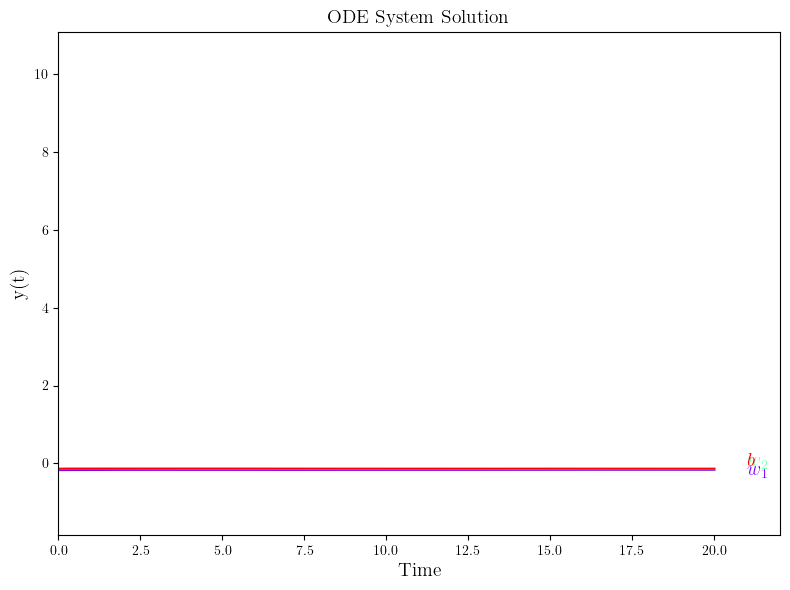

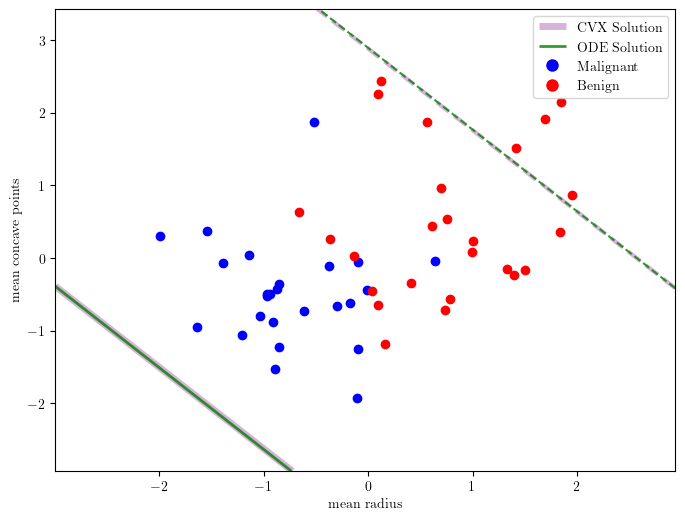

epsilon: inf time: 3811.7763550281525 iterations: 10000


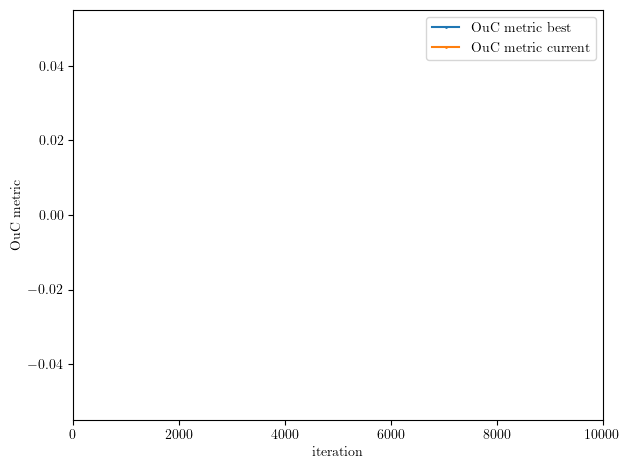

Last losses: [0.29915371537208557, 0.34408190846443176, 0.4035760462284088, 0.4468850791454315, 0.6384297609329224, 1.0664384365081787, 1.367159128189087, 1.4286503791809082, 1.4798493385314941, 1.5554879903793335]


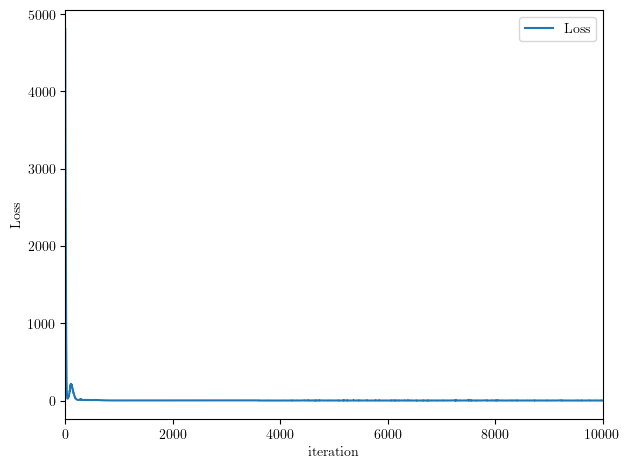

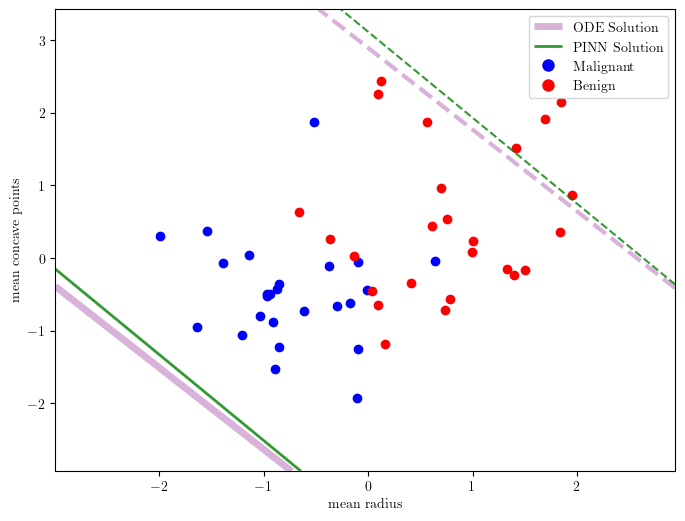

Variables: [-0.17363086 -0.14684168 -0.14899664 -0.19412762  0.23650394  0.31937164
 -0.02967945 -0.11741544  0.18816409  0.06209595 -0.12705636  0.12906595
 -0.13181046 -0.2596841  -0.4523027   0.14030598  0.0635912  -0.08061393
  0.04539801 -0.01479076 -0.25629732 -0.56106097 -0.1924983  -0.25762418
 -0.76180255  0.03209345 -0.16698782 -0.39070392 -0.28241396 -0.4473938
 -0.5429085   0.01063786  0.00199969 -0.00174436 -0.00223863  0.00298524
 -0.01353612  0.00566022 -0.00687784 -0.00062418  0.00344763 -0.00212625
 -0.00016018  0.0074664  -0.00158511  0.00742694 -0.00680243  0.01317028
  0.00315873  0.01554706  0.01167425  0.01154622 -0.00169325  0.00487372
 -0.00560745  0.00343125 -0.00013115 -0.00786483 -0.01042187 -0.00095285
  0.01294042 -0.00706173 -0.02146176  0.01557162 -0.00281315 -0.00122552
  0.00011714 -0.01256823 -0.01009497  0.00330629 -0.00316289  0.00165352
  0.01708182 -0.00248957 -0.01082682  0.01706117  0.00865237  0.00334757
  0.01368888 -0.01244204  0.01121453]
Con

Time: 9.433945417404175
objective: 1.0909523 lim: 0.1
objective: 1.0909523
w:  [-0.16893246 -0.15065124 -0.13757441 -0.19053101  0.24248692  0.30311023
 -0.02768983 -0.10444885  0.1848775   0.05933417 -0.14101217  0.1365906
 -0.12470406 -0.25410568 -0.45103649  0.14858882  0.05369815 -0.06559967
  0.03927577 -0.02483287 -0.25920587 -0.56306301 -0.20249603 -0.26040225
 -0.76423711  0.03983865 -0.15389338 -0.37939659 -0.2656341  -0.45432802] b:  -0.5657157914767494
hyperplane similarity: 7.686509351301218e-05
Dual variables (alpha): [-0.16893246 -0.15065124 -0.13757441 -0.19053101  0.24248692  0.30311023
 -0.02768983 -0.10444885  0.1848775   0.05933417 -0.14101217  0.1365906
 -0.12470406 -0.25410568 -0.45103649  0.14858882  0.05369815 -0.06559967
  0.03927577 -0.02483287 -0.25920587 -0.56306301 -0.20249603 -0.26040225
 -0.76423711  0.03983865 -0.15389338 -0.37939659 -0.2656341  -0.45432802
 -0.56571579 -0.00000047  0.00000048  0.00000048  0.00000048 -0.00000064
 -0.00000032 -0.00000047  

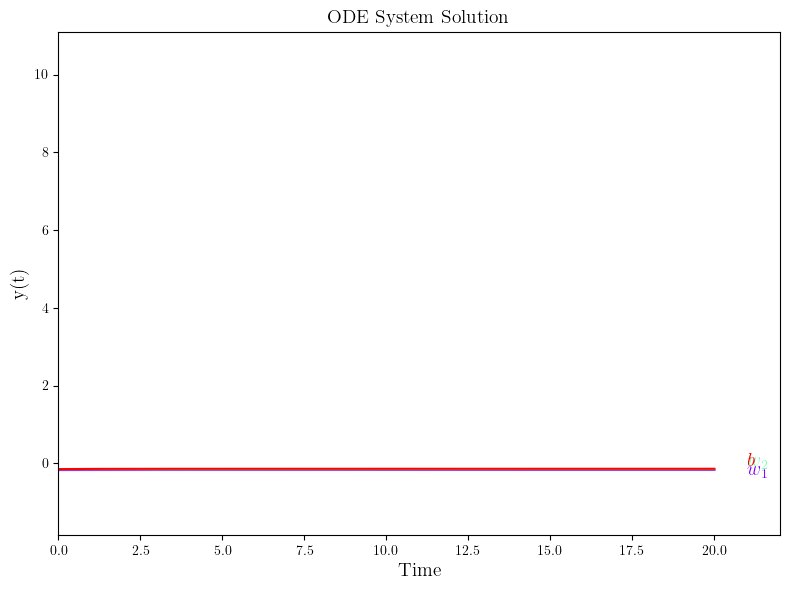

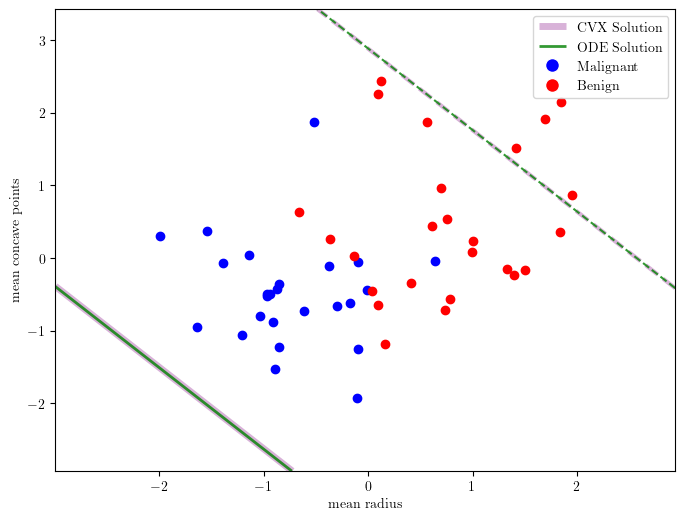

epsilon: 0.8519857 time: 3782.3910393714905 iterations: 10000


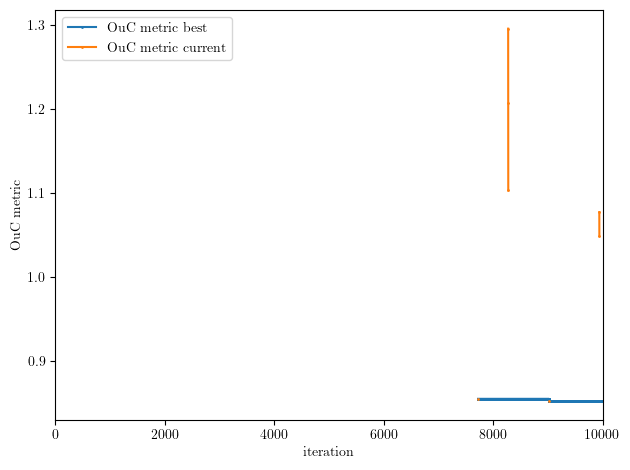

Last losses: [0.5870527029037476, 0.5754041075706482, 0.46564704179763794, 0.33614644408226013, 0.21481502056121826, 0.15106061100959778, 0.11374916136264801, 0.08094483613967896, 0.08839982748031616, 0.11155843734741211]


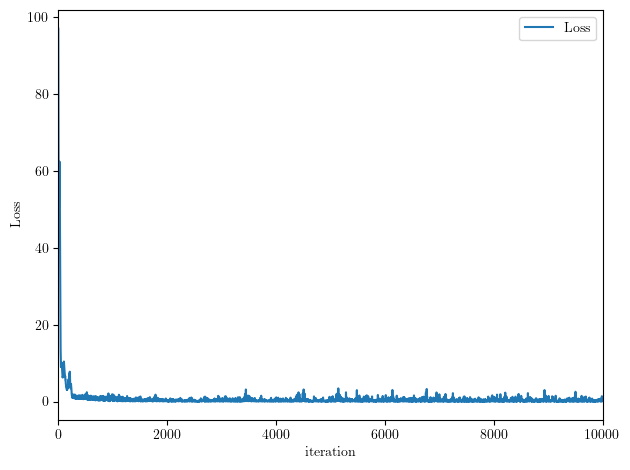

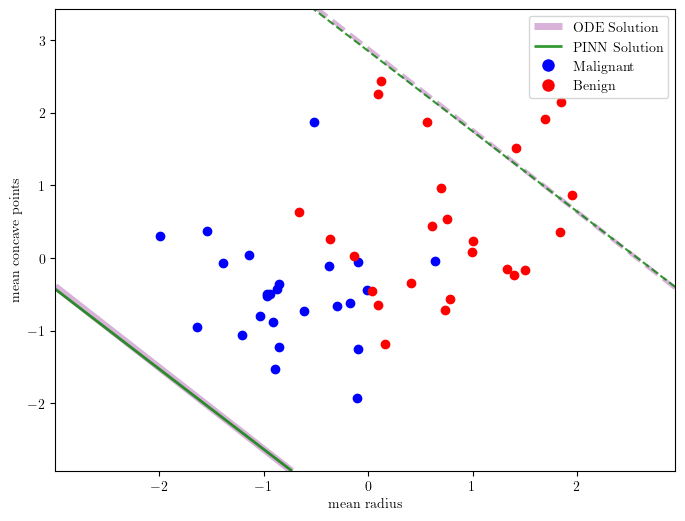

Variables: [-0.16760737 -0.15179673 -0.1395519  -0.19352144  0.24259871  0.30112803
 -0.03224772 -0.10487299  0.18859443  0.05722189 -0.13794829  0.13643205
 -0.13016321 -0.25667697 -0.44655344  0.15294187  0.06660396 -0.06844331
  0.03761091 -0.02690928 -0.26219705 -0.5635569  -0.20103921 -0.26838177
 -0.76606274  0.03093102 -0.15872303 -0.38501304 -0.2637723  -0.44377246
 -0.5676462   0.00007846 -0.00412552 -0.00128969 -0.00184462 -0.0014327
  0.00060122  0.00166884 -0.00649132 -0.00266808  0.00030788 -0.00828539
 -0.00091748  0.00018565 -0.00503718  0.0049835  -0.00427153 -0.00389768
 -0.00364459 -0.00466327 -0.00237986  0.00020748  0.00475376  0.00348983
  0.00030445  0.00653946 -0.00005279  0.00114273  0.00526085 -0.0063763
 -0.00023666  0.00774937 -0.00119525  0.00776419  0.00786544  0.00282426
  0.00028166  0.0053466   0.0065658  -0.00165521 -0.00694599  0.01036914
 -0.00960073  0.00469918  0.00618701 -0.00695465 -0.00390989  0.01111954
 -0.00085693  0.00086591 -0.00084818]
Cons

Time: 13.741403102874756
objective: 1.0921041 lim: 0.001
objective: 1.0921041
w:  [-0.16903975 -0.15077236 -0.13768854 -0.19063513  0.24229548  0.30308148
 -0.02738272 -0.10445767  0.18529203  0.05976812 -0.1408858   0.13690323
 -0.12477812 -0.25409638 -0.45105068  0.14880821  0.05459366 -0.06511727
  0.03923933 -0.02391137 -0.25930697 -0.56313283 -0.20264372 -0.26050768
 -0.76432327  0.03950611 -0.15383876 -0.3795553  -0.2655634  -0.45418179] b:  -0.5655400617583997
hyperplane similarity: 1.0779470302452188e-05
Dual variables (alpha): [-0.16903975 -0.15077236 -0.13768854 -0.19063513  0.24229548  0.30308148
 -0.02738272 -0.10445767  0.18529203  0.05976812 -0.1408858   0.13690323
 -0.12477812 -0.25409638 -0.45105068  0.14880821  0.05459366 -0.06511727
  0.03923933 -0.02391137 -0.25930697 -0.56313283 -0.20264372 -0.26050768
 -0.76432327  0.03950611 -0.15383876 -0.3795553  -0.2655634  -0.45418179
 -0.56554006 -0.00000048  0.00000048 -0.00000047 -0.00000048  0.00000047
 -0.00000048 -0.0000

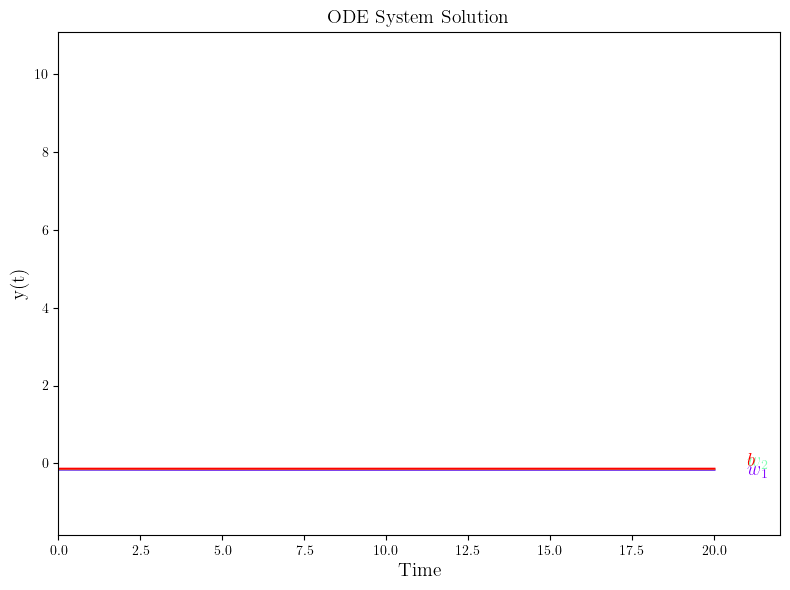

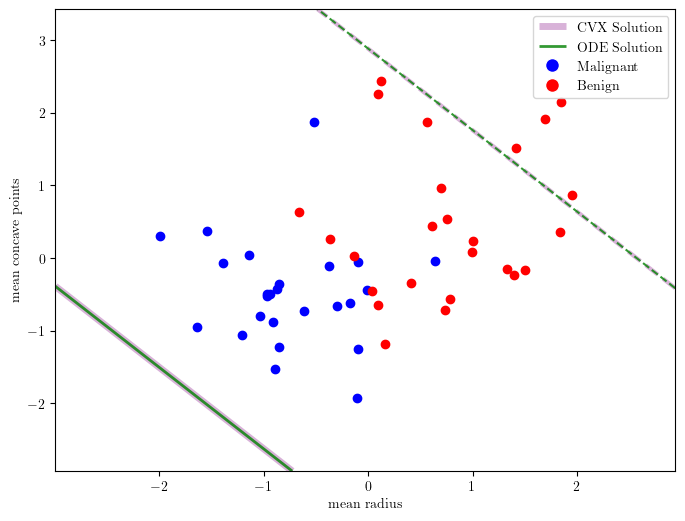

epsilon: inf time: 3788.525352716446 iterations: 10000


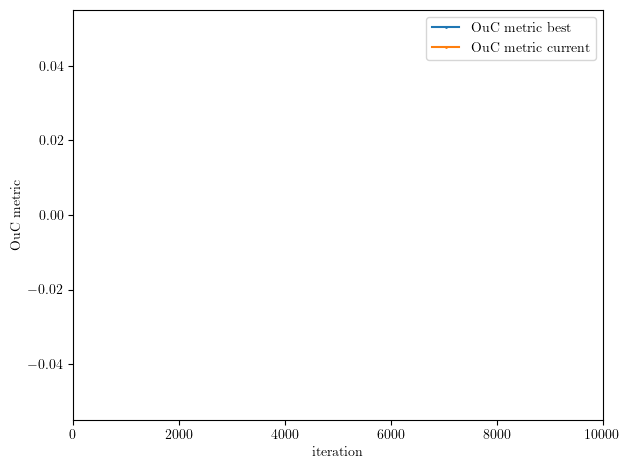

Last losses: [0.19944535195827484, 0.2891855835914612, 0.2414538860321045, 0.14481337368488312, 0.1356353908777237, 0.07484717667102814, 0.047247979789972305, 0.0644710436463356, 0.08535705506801605, 0.06618428230285645]


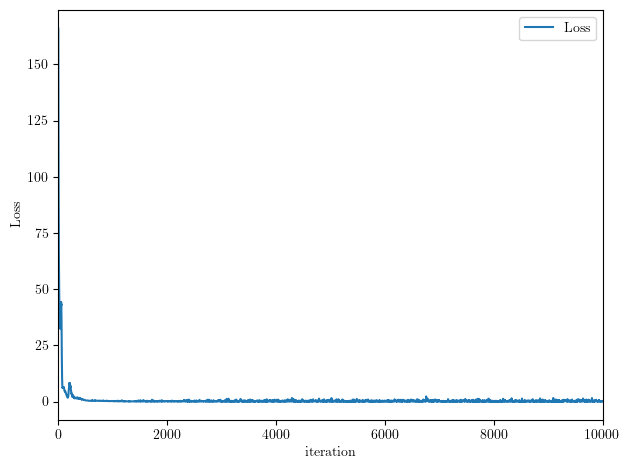

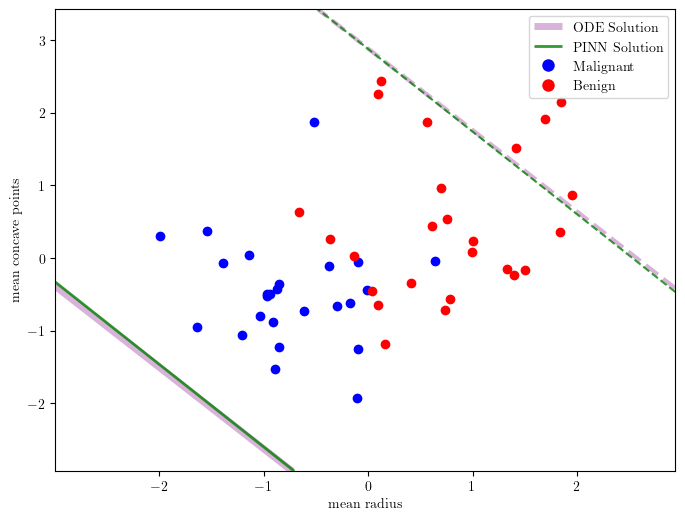

Variables: [-0.17181924 -0.15115952 -0.13586894 -0.18671885  0.23344064  0.30421266
 -0.0263998  -0.09781833  0.18889247  0.06159531 -0.14017119  0.134527
 -0.12622268 -0.26047695 -0.44785503  0.14385056  0.05716229 -0.06803257
  0.03541474 -0.03069985 -0.25778672 -0.563871   -0.20087749 -0.25927418
 -0.7709839   0.03978717 -0.15405807 -0.37470973 -0.26167744 -0.44970542
 -0.56527656 -0.00975673  0.00787425 -0.00609502  0.00425387 -0.01354702
 -0.01036302 -0.00900058  0.0046884   0.00015993 -0.00975352 -0.00863633
  0.00626453 -0.00346292  0.01495735 -0.01021117 -0.00310319 -0.00818159
  0.0029619   0.008904   -0.01282786  0.00359534 -0.01900407  0.00184499
  0.00868045 -0.00634979  0.00697254 -0.00971186  0.00543922 -0.00927335
  0.00371898 -0.00591979  0.00476568 -0.00850649  0.01253912  0.00139746
 -0.02033324 -0.00282016  0.00526996 -0.01366104 -0.00437331  0.01149868
 -0.00133495 -0.00043197 -0.01312885 -0.01126944  0.00483662  0.01117504
 -0.00372399 -0.00261235 -0.00489326]
Cons

Time: 20.658743143081665
objective: 1.0918511 lim: 0.01
objective: 1.0918511
w:  [-0.16901697 -0.15078115 -0.13765578 -0.19062097  0.2424149   0.303211
 -0.02747967 -0.10436628  0.1851265   0.05955481 -0.14095267  0.13694285
 -0.12471298 -0.25408569 -0.45101022  0.14877181  0.05408857 -0.06539476
  0.03925324 -0.02448079 -0.25925957 -0.5630257  -0.20255106 -0.26046559
 -0.76418959  0.03980479 -0.1537899  -0.37941958 -0.26558252 -0.45425577] b:  -0.5656611751025314
hyperplane similarity: 4.953621778372441e-05
Dual variables (alpha): [-0.16901697 -0.15078115 -0.13765578 -0.19062097  0.2424149   0.303211
 -0.02747967 -0.10436628  0.1851265   0.05955481 -0.14095267  0.13694285
 -0.12471298 -0.25408569 -0.45101022  0.14877181  0.05408857 -0.06539476
  0.03925324 -0.02448079 -0.25925957 -0.5630257  -0.20255106 -0.26046559
 -0.76418959  0.03980479 -0.1537899  -0.37941958 -0.26558252 -0.45425577
 -0.56566118 -0.0000004  -0.00000048  0.00000048 -0.00000048  0.00000002
  0.00000048 -0.00000048 -

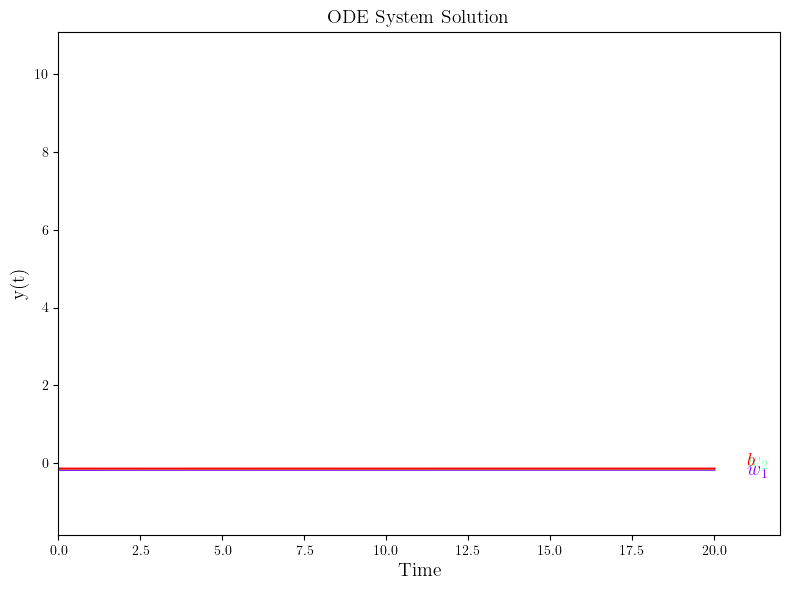

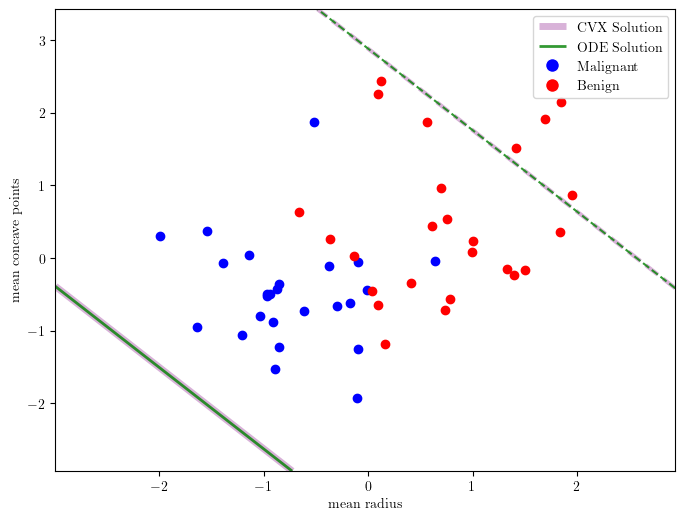

epsilon: 0.75844246 time: 3803.8540711402893 iterations: 10000


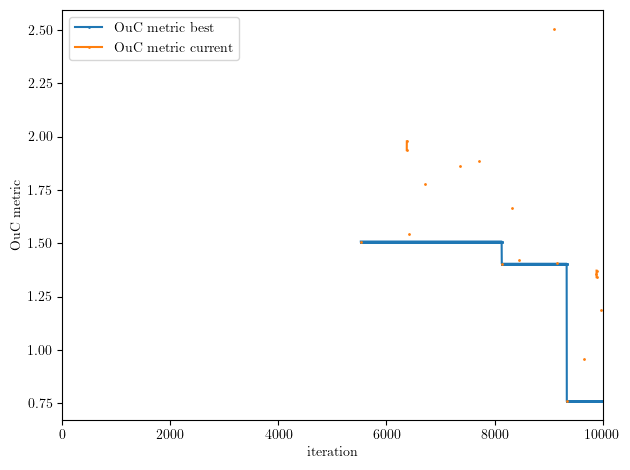

Last losses: [0.2446797639131546, 0.06332404911518097, 0.16037923097610474, 0.22949105501174927, 0.24911847710609436, 0.1928366720676422, 0.08854974061250687, 0.2133578360080719, 0.5424067974090576, 0.4634144902229309]


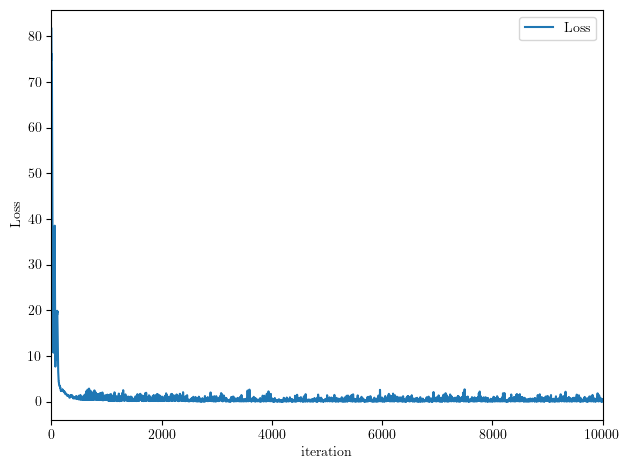

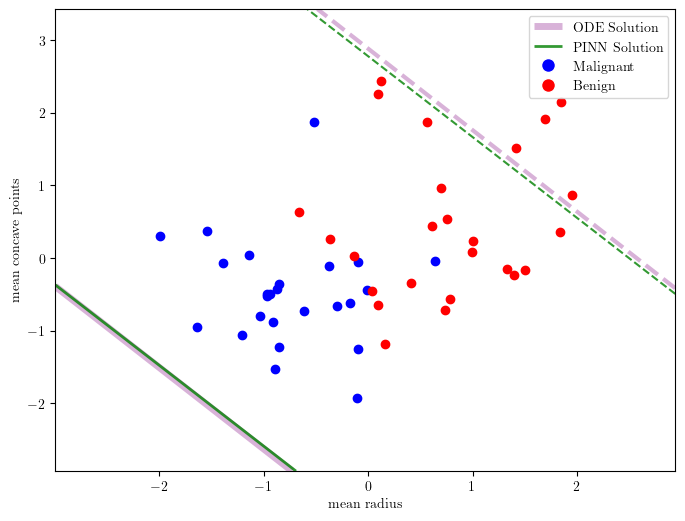

Variables: [-0.17159325 -0.15431777 -0.12681678 -0.18852873  0.24032678  0.3038344
 -0.02542613 -0.10281904  0.17460033  0.06775515 -0.14118883  0.13443634
 -0.12518959 -0.25627536 -0.45017213  0.15693176  0.05482739 -0.06500824
  0.03939728 -0.03120767 -0.2506782  -0.56203544 -0.19334137 -0.26739398
 -0.76749253  0.03574746 -0.15734035 -0.37972096 -0.26439953 -0.45804203
 -0.57158995  0.00281338  0.00486398  0.00423508  0.00311498  0.00018984
 -0.00601031  0.00263205 -0.009171   -0.00246618  0.00028849  0.00401457
  0.00743592 -0.01035564 -0.00996122 -0.00085679 -0.00005365 -0.00939881
 -0.00303304  0.0007961   0.00544839 -0.00289298  0.01151323 -0.00191803
  0.00452174 -0.00194584 -0.00427573  0.00156272 -0.01011879 -0.00950778
  0.01176246 -0.00682923 -0.0011393   0.00900374  0.00466219  0.01275023
 -0.00705886  0.00788758  0.00842124 -0.00601333  0.003843   -0.00152199
 -0.00828646  0.00034517 -0.0005894  -0.00064322  0.00155318  0.00466556
 -0.00169286 -0.01075883 -0.00431278]
Con

Time: 18.78961706161499
objective: 1.0919058 lim: 0.01
objective: 1.0919058
w:  [-0.16904797 -0.15085291 -0.13768321 -0.19065652  0.24243212  0.30327441
 -0.02741641 -0.10431711  0.18521079  0.05962043 -0.14093901  0.13704865
 -0.12470953 -0.25407805 -0.4509709   0.14882513  0.05415471 -0.06535605
  0.03924817 -0.02442807 -0.25927619 -0.56303555 -0.20256232 -0.26048642
 -0.76413107  0.03983457 -0.15374869 -0.37940435 -0.26555491 -0.45422755] b:  -0.565674793537204
hyperplane similarity: 5.374595860369036e-05
Dual variables (alpha): [-0.16904797 -0.15085291 -0.13768321 -0.19065652  0.24243212  0.30327441
 -0.02741641 -0.10431711  0.18521079  0.05962043 -0.14093901  0.13704865
 -0.12470953 -0.25407805 -0.4509709   0.14882513  0.05415471 -0.06535605
  0.03924817 -0.02442807 -0.25927619 -0.56303555 -0.20256232 -0.26048642
 -0.76413107  0.03983457 -0.15374869 -0.37940435 -0.26555491 -0.45422755
 -0.56567479 -0.00000048 -0.00000047  0.00000048 -0.00000047  0.00000047
  0.00000048  0.00000048

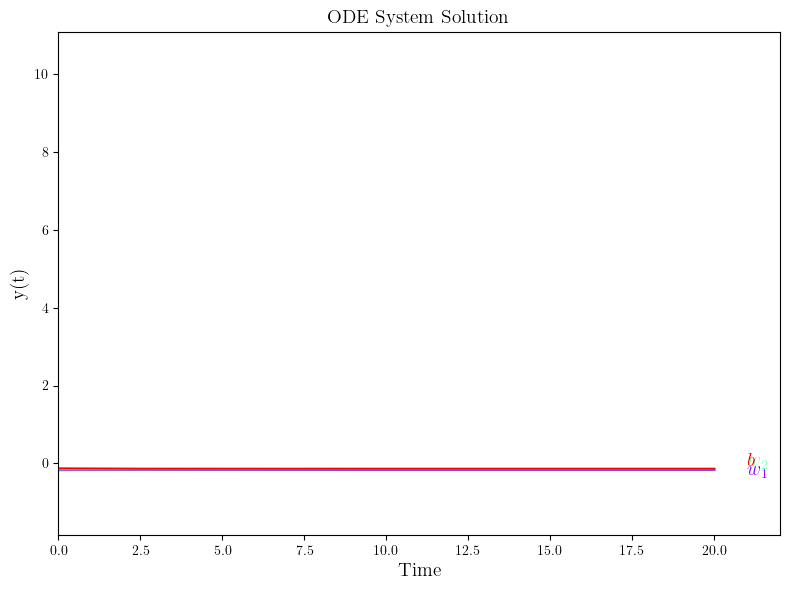

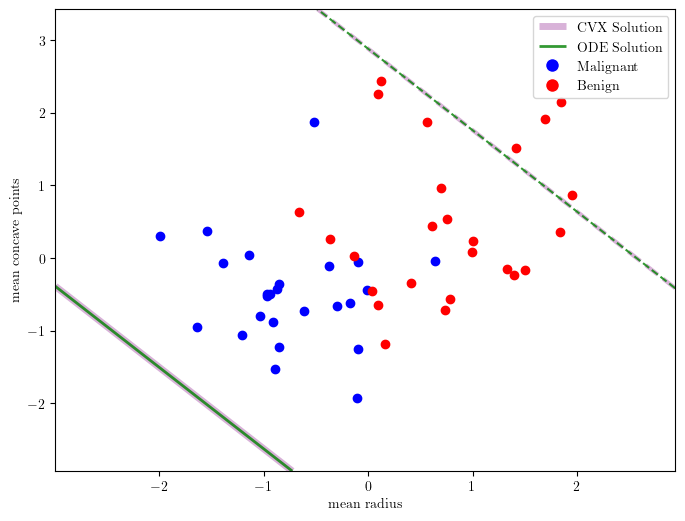

epsilon: 2.1136012 time: 3792.7318634986877 iterations: 10000


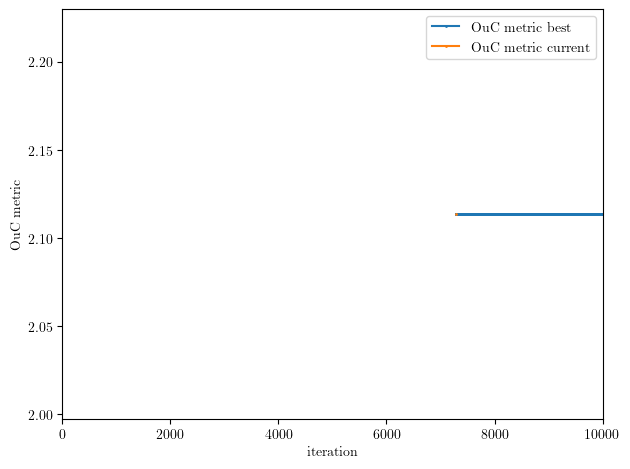

Last losses: [0.11031436175107956, 0.0956348329782486, 0.07008210569620132, 0.05471184104681015, 0.044899679720401764, 0.07056032121181488, 0.046999745070934296, 0.12963515520095825, 0.17252784967422485, 0.11999853700399399]


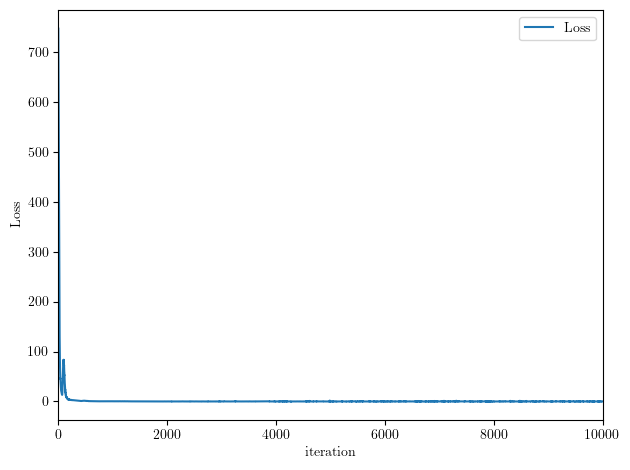

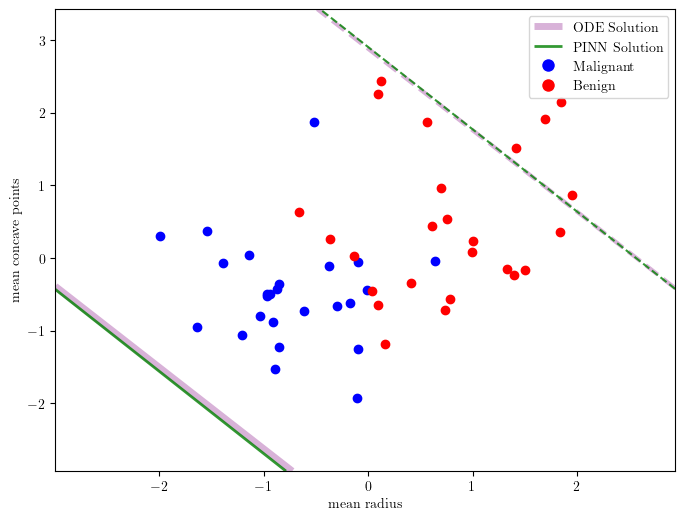

Variables: [-0.16819955 -0.14860532 -0.13832091 -0.19348346  0.24807224  0.31237411
 -0.02813766 -0.10224706  0.1844607   0.05921555 -0.14235365  0.13764422
 -0.11556    -0.25236994 -0.4584385   0.15007979  0.05559313 -0.06904077
  0.04212752 -0.01635094 -0.25976485 -0.56816596 -0.19991565 -0.25685257
 -0.77082026  0.0385612  -0.15412594 -0.38668326 -0.2613026  -0.4633193
 -0.5686081   0.00273069  0.01463724  0.01108437  0.01094084 -0.00445221
 -0.00166452  0.00280958  0.00869515 -0.03725579  0.00098349 -0.0079838
 -0.0175382  -0.01833285 -0.00014378 -0.01351538  0.00082327 -0.01174774
  0.01512387  0.00082025 -0.01871186 -0.00910486 -0.00004054 -0.00429753
  0.00749929  0.00068758  0.00602145  0.00560769 -0.00062101  0.01868287
  0.006565   -0.00879634  0.00960655  0.02529089  0.02234934 -0.00324024
  0.00088048 -0.00749027  0.01157639 -0.01405612 -0.01462376 -0.0057758
 -0.00035913  0.00896265  0.00077937  0.01196671  0.00732469  0.0127499
 -0.00537853  0.00973211 -0.00859545]
Constr

In [14]:
ITERATIONS = 2000
LR = 0.01
ip = np.zeros(NY)
ip[:nw + nb] = 1.0

for i in range(8):
    print('>>>> ITERATION:', i+1)
    res, pinn_obj, lastIter = iteration(ip)
    wb_pinn = res[:nw+1]
    if lastIter:
        print('>>>> Results obtained, OuC: ', pinn_obj)
        break
    ip = res
    ITERATIONS = 10000
    LR = 0.0001